In [ ]:
import numpy as np
import time
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import MaxNLocator
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, hamming_loss
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import BatchNormalization
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import math

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

import warnings
warnings.filterwarnings("ignore")


## Definition of Evaluation Metrics for Model Training and Validation

Since Keras (with the TensorFlow backend) does not directly provide some relevant metrics through keras.metrics, it was necessary to implement them manually for this work.

Specifically, the following metrics were implemented: F1-Score (weighted), Hamming Loss, and Hamming Score, considering their suitability for the multilabel classification context. The implementation of these metrics is presented in the following cell.


In [ ]:
def f1_score_weighted(y_true, y_pred):
    if isinstance(y_pred, (list, tuple)):
        y_pred = y_pred[0]

    y_pred = K.round(y_pred)
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.cast(y_pred, K.floatx())


    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

     # Weighting by support (number of samples per class)
    support = K.sum(y_true, axis=0)
    f1_weighted = K.sum(f1 * support) / K.sum(support)

    return f1_weighted


def hamming_score(y_true, y_pred):
    if isinstance(y_pred, (list, tuple)):
        y_pred = y_pred[0]
    y_pred = K.round(y_pred)
    y_true = K.cast(y_true, K.floatx())
    correct = K.equal(y_true, y_pred)
    return K.mean(K.cast(correct, K.floatx()))

## Dataset Loading

The dataset used contains 11,205 frequency records of events detected in the Brazilian Interconnected Power System (BIPS) over a 12-year period, including both historical event data and records obtained from the application of the event detection methodology proposed in [1]. All records were manually inspected, and one or more event classes were assigned to each detection based on the observed dynamics: Line Tripping (LnT), Electromechanical Oscillations (EO), Loss of Load (LoL) and Generation Tripping (GT). As a result, 9,003 records were labeled with the LnT class, 4,844 with EO, 622 with LoL, and 1,007 with GT.



Nevertheless, due to confidentiality restrictions, the dataset cannot be shared publicly.



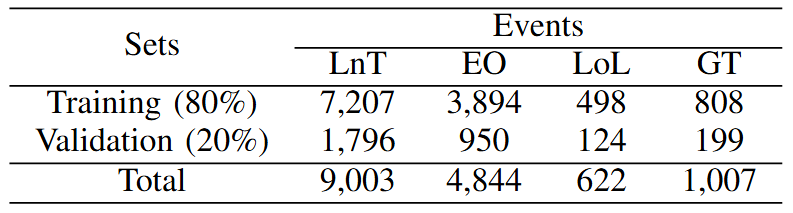


[1] Gabriel V. de S. Lopes, Guido R. Moraes, Diego Issicaba, Daniel Dotta, WAMS-based two-level robust detection methodology of power system events, Sustainable Energy, Grids and Networks, Volume 31, 2022, 100689, ISSN 2352-4677, https://doi.org/10.1016/j.segan.2022.100689.

In [ ]:
rlist = np.load('/content/drive/MyDrive/Dataset_VIT_img/Train_Events_10_22_class_multilabel_img_CA_media_var_sem_ruido_v3.npz', allow_pickle=True)
X_train = rlist['data']
Train_label_class = rlist['label']
Y_train = np.array(Train_label_class)

# Reshaping the input data matrix to the channel-last format
number_rows, number_cols = X_train.shape[1], X_train.shape[2]
TrainX_arr = X_train.reshape(X_train.shape[0], number_rows, number_cols, 3)

In [ ]:
label_np = np.array(Train_label_class)
print({'LT': (label_np[:,0] != 0).sum(), 'OSC': (label_np[:,1] != 0).sum(), 'PC': (label_np[:,2] != 0).sum(), 'PG': (label_np[:,3] != 0).sum()})

{'LT': np.int64(7195), 'OSC': np.int64(3864), 'PC': np.int64(495), 'PG': np.int64(807)}


In [ ]:
rlist = np.load('/content/drive/MyDrive/Dataset_VIT_img/Val_Events_10_22_class_multilabel_img_VF_CA_media_var_sem_ruido_v3.npz', allow_pickle=True)
X_val = rlist['data']
Val_label = rlist['label']
Y_val = np.array(Val_label)

# Reshaping the input data matrix to the channel-last format
valX_arr = X_val.reshape(X_val.shape[0], number_rows, number_cols, 3)

In [ ]:
label_np = np.array(Val_label)
print({'LT': (label_np[:,0] != 0).sum(), 'OSC': (label_np[:,1] != 0).sum(), 'PC': (label_np[:,2] != 0).sum(), 'PG': (label_np[:,3] != 0).sum()})

{'LT': np.int64(1808), 'OSC': np.int64(980), 'PC': np.int64(119), 'PG': np.int64(200)}


## Function: PatchExtractor()

The PatchExtractor function aims to divide an image into smaller regions called patches, which are fixed-size pixel blocks used as basic input units in architectures such as the Vision Transformer (ViT). To achieve this, the function employs the tf.image.extract_patches operation, which scans the image using sliding windows of dimension patch_size × patch_size (16x16), extracting the fragments in a non-overlapping manner (stride equal to the patch size).

In [ ]:
patch_size = 16  # Tamanho dos patches para o Vision Transformer (ViT)

class PatchExtractor(layers.Layer):
    def __init__(self, patch_size):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]  # Dynamically get batch size
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],  # Patch size
            strides=[1, self.patch_size, self.patch_size, 1],  # Patch stride
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = tf.shape(patches)[-1]  # Dynamically compute patch dimensions
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])  # Reshape patches
        return patches

### Example of dividing an input of size 320×320 into patches

For instance, consider an input image with dimensions 320×320 pixels. Using a patch size of 16×16, the PatchExtractor function will partition the image into non-overlapping patches. Each patch contains 16×16 pixels, resulting in a total of 320/16 × 320/16 = 20×20 = 400 patches.

(5, 320, 320, 3)


Image size: 320 X 320
Patch size: 16 X 16
Patches per image: 400
Elements per patch: 768


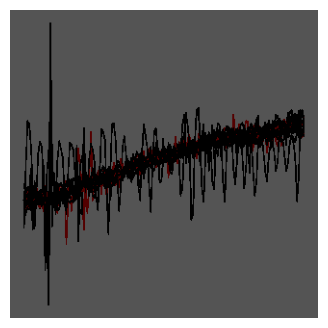

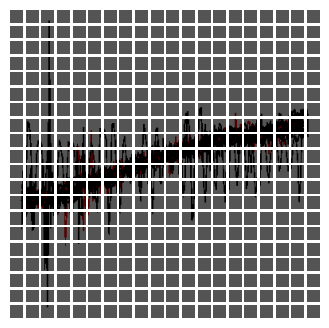

In [ ]:
index = 0  # Index of the image in the training dataset
number_of_bands = 1  # Number of bands used in the image data

# Selecting a sample data from the training dataset with specified number of bands
sample_data = X_train[index:index+5, :, :,0:3]

image_int_normalized = np.clip(sample_data, 0, 255)
print(image_int_normalized.shape)

# Extracting patches from the sample data
patches = PatchExtractor(patch_size)(image_int_normalized)

plt.figure(figsize=(4, 4))

# num_patches = (image_size // patch_size) ** 2

plt.imshow(sample_data[0])
plt.axis('off')

# patches = Patches(patch_size)(resized_image)
print(f'Image size: {320} X {320}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

# Visualizing the extracted patches
n = int(np.sqrt(patches.shape[1]))  # Number of patches to display in each dimension
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size,3))
    plt.imshow(patch_img.numpy())  # Displaying the patch image
    plt.axis("off")  # Turning off axis

## Function: patch_encoder()

The patch_encoder function aims to transform each extracted image patch into a vector representation (embedding) suitable for processing by a Vision Transformer (ViT). For each input patch, the function applies a dense layer that projects the pixel values into a space of dimensionality defined by projection_dim (in this case, 128). In parallel, a positional embedding vector is generated, encoding the relative position of each patch within the image, allowing the model to retain spatial information. The final representation of each patch is obtained by adding the dense projection to the corresponding positional embedding, resulting in a sequence of vectors of dimension projection_dim for all image patches. In this way, the function converts the image from its original matrix form into a sequence of positionally encoded embeddings, which can be sequentially processed by attention mechanisms, as used in Transformers.

In [ ]:
projection_dim = 128  # Dimensionality of the projected embeddings

def patch_encoder(patch, img_size, projection_dim):

    num_patches = (img_size // patch_size) ** 2

    positions = tf.range(start=0, limit=num_patches, delta=1)  # Generating positional embeddings

    # Embedding layer for positional embeddings
    emd = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)

    # Dense layer for encoding the patch
    dens = layers.Dense(units=projection_dim)(patch)

    # Adding positional embeddings and patch encoding
    encoded = emd + dens

    return encoded


## Function: mlp()

Defines a Multi-Layer Perceptron (MLP) block.

    Args:
        x: Input tensor.
        hidden_units: List of integers specifying the number of units in each hidden layer.
        dropout: Dropout rate for the dropout layers.

    Returns:
        x: Output tensor after passing through the MLP block.

In [ ]:
transformer_units = [
  projection_dim * 2,
  projection_dim,
]  # Size of the transformer layers

def mlp(x, hidden_units, dropout):
    for units, drop in zip(hidden_units, dropout):
    # for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)  # Fully connected layer with GELU activation
        x = layers.Dropout(drop)(x)  # Dropout layer
    return x

## Function: get_attention_weights()

The get_attention_weights function computes the attention weights of a Multi-Head Attention (MHA) layer for a given input x. It first projects the input into queries (q), keys (k), and values (v) using the MHA’s internal dense layers. Each of these is then split into multiple heads, allowing parallel attention computation over subspaces of the embeddings. The attention scores are calculated as the scaled dot product of q and k, followed by a softmax to produce normalized weights. The resulting tensor, attn_weights, indicates the relevance of each sequence element to the others across all attention heads.

In [ ]:
def get_attention_weights(mha_layer, x):

    num_heads = mha_layer.num_heads
    key_dim = mha_layer.key_dim

    # Projeções lineares
    q = mha_layer._query_dense(x)
    k = mha_layer._key_dense(x)
    v = mha_layer._value_dense(x)

    # Função para separar as cabeças
    def split_heads(x):
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]
        depth = x.shape[2] // num_heads
        x = tf.reshape(x, (batch_size, seq_len, num_heads, depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch, heads, seq_len, depth)

    q = split_heads(q)
    k = split_heads(k)
    v = split_heads(v)

    # Atenção escala produto ponto
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    scaled_logits = matmul_qk / tf.math.sqrt(tf.cast(key_dim, tf.float32))
    attn_weights = tf.nn.softmax(scaled_logits, axis=-1)

    return attn_weights

## Function: vit_model ()

For the implementation of the proposed event classifier, a hybrid architecture based on the Vision Transformer (ViT) was adopted. Initially, a CNN with two convolutional layers (128 and 256 filters, GELU activation), followed by batch normalization, max-pooling, and dropout (0.4 and 0.5), extracts features from the input signals. These feature maps are divided into 25 patches of size 16×16, which are linearly projected into embeddings of 128 dimensions and enriched with positional encoding.

The sequence of embeddings is then processed by two transformer blocks, each composed of layer normalization, a 6-head self-attention mechanism with skip connections, and an MLP (256 and 128 neurons, GELU activation, dropout 0.6).

Finally, classification is performed by an MLP with 64 neurons, dropout (0.5), and a sigmoid output layer with four neurons, producing the probabilities for each event class.


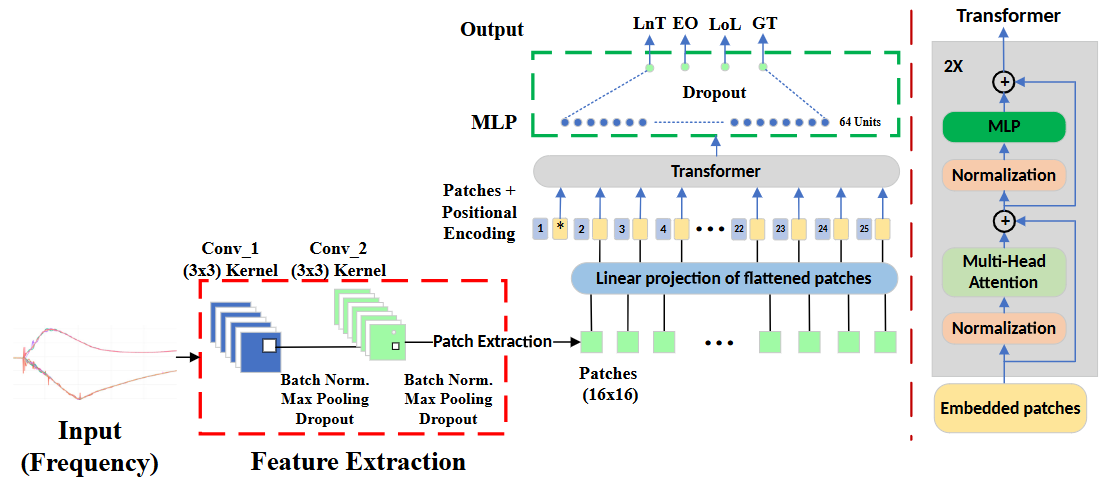




In [ ]:
number_of_heads=6
transformer_layers=2

def vit_model(input_shape):
  inputs=layers.Input(shape=input_shape)

  x = layers.Conv2D(128, (3, 3), activation="gelu", padding="same")(inputs)
  x=  BatchNormalization(momentum = 0.9)(x)
  x = layers.MaxPooling2D((2, 2))(x)
  x = layers.Dropout(0.4)(x)
  x = layers.Conv2D(256, (3, 3), activation="gelu", padding="same")(x)
  x=  BatchNormalization(momentum = 0.9)(x)
  x = layers.MaxPooling2D((2, 2))(x)
  x = layers.Dropout(0.5)(x)

  # Extract patches from input image
  patches = PatchExtractor(patch_size)(x)
  #Patch Encoder
  Encoded_patches=patch_encoder(patches, x.shape[1], projection_dim)

  attention_maps = []
  # Create a multiple transformer layer.
  for _ in range(transformer_layers):

    x1=layers.LayerNormalization(epsilon=1e-6)(Encoded_patches)
    # print(x1.shape)

    # Create a multi-head attention layer.
    mha_layer =layers.MultiHeadAttention(
        num_heads=number_of_heads,
        key_dim=projection_dim,
        dropout=0.2,

    )

    attention_output, attn_weights = mha_layer(x1, x1, x1, return_attention_scores=True)

    attention_maps.append(attn_weights)  # Armazena os pesos de atenção

    # Create skip connection
    x2=layers.Add()([attention_output,Encoded_patches])
    # print(x2.shape)

    # Normalization layer
    x3=layers.LayerNormalization(epsilon=1e-6)(x2)
    # print(x3.shape)

    # MLP section
    x3=mlp(x3,hidden_units=transformer_units,dropout=[0.6,0.6])

    # Skip connection
    Encoded_patches=layers.Add()([x3,x2])
    # print(Encoded_patches)

  # Create a [batch_size, projection_dim] tensor.
  representation = layers.LayerNormalization(epsilon=1e-6)(Encoded_patches)  # Layer normalization
  representation = layers.Flatten()(representation)  # Flatten the tensor
  representation = layers.Dropout(0.6)(representation)  # Dropout layer

  # Add MLP.
  features = mlp(representation, hidden_units=[64], dropout=[0.5])  # Apply MLP to the representation

  # Classify outputs.
  logits = layers.Dense(4, activation='sigmoid')(features)  # Dense layer with softmax activation for classification

  # Create the Keras model.
  model = keras.Model(inputs=inputs, outputs=[logits] + attention_maps)  # Define the model with input and output layers

  return model


In [ ]:
model = vit_model((number_rows, number_cols, 3))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 320, 320,  │      3,584 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 320, 320,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 160, 160,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 160, 160,  │          0 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 160, 160,  │    295,168 │ dropout[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 160, 160,  │      1,024 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 80, 80,    │          0 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_extractor_1   │ (None, None,      │          0 │ dropout_1[0][0]   │
│ (PatchExtractor)    │ 65536)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 128) │  8,388,736 │ patch_extractor_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 25, 128)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 25, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ [(None, 25, 128), │    395,648 │ layer_normalizat… │
│ (MultiHeadAttentio… │ (None, 6, 25,     │            │ layer_normalizat… │
│                     │ 25)]              │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 25, 128)   │          0 │ multi_head_atten… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 25, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 25, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 9,818,564 (37.45 MB)

 Trainable params: 9,817,796 (37.45 MB)

 Non-trainable params: 768 (3.00 KB)

## Model Training

The model will initially be trained for up to 100 epochs, with a batch size of 32. However, if no improvement in performance is observed—measured by a reduction in validation loss greater than 0.0001 over 5 consecutive epochs—the training will be stopped early. The applied early stopping technique aims to prevent model overfitting, ensuring better generalization.

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.95
)

BASE_LR = 1e-4
WEIGHT_DECAY = 1e-4
loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)

optimizer = tf.keras.optimizers.AdamW(learning_rate=BASE_LR, weight_decay=WEIGHT_DECAY)  # Adam optimizer with specified learning rate

num_attention_maps = len(model.outputs) - 1

losses_list = [loss_fn] + [None] * num_attention_maps

metrics_list = [
    ['accuracy', hamming_score, f1_score_weighted]  # métricas para a predição (primeira saída)
] + [None] * num_attention_maps

model.compile(
    optimizer=optimizer,  # Set the optimizer
    loss=losses_list,  # Categorical crossentropy loss function
    metrics=metrics_list,  # Evaluation metric: accuracy
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitora a métrica de validação (pode ser 'val_accuracy' também)
    patience=5,          # Número de épocas sem melhora antes de parar
    min_delta=0.0001,
    mode='min',
    restore_best_weights=True  # Restaura os melhores pesos ao final do treinamento
)

history = model.fit(
    X_train,  # Training data
    Y_train,  # Training labels
    epochs=100,  # Number of epochs
    batch_size=32,
    validation_data=(X_val, Val_label),
    callbacks=[early_stopping]# Validation data and labels
)

In [ ]:
from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='Training')
pyplot.plot(history.history['val_loss'], label='Validation')
pyplot.legend()


# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='Training')
pyplot.plot(history.history['val_accuracy'], label='Validation')
pyplot.legend()

plt.subplots_adjust(hspace=0.5)

pyplot.show()

# plot accuracy during training
pyplot.subplot(211)
pyplot.title('F1-score')
pyplot.plot(history.history['f1_score_weighted'], label='Training')
pyplot.plot(history.history['val_f1_score_weighted'], label='Validation')
pyplot.legend()


# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Hamming Score')
pyplot.plot(history.history['hamming_score'], label='Training')
pyplot.plot(history.history['val_hamming_score'], label='Validation')
pyplot.legend()

plt.subplots_adjust(hspace=0.5)

pyplot.show()

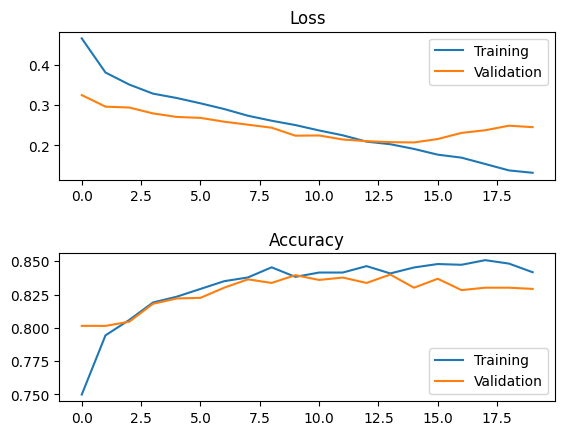


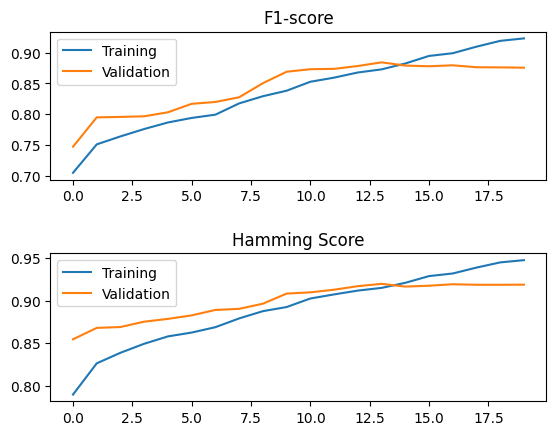

In [ ]:
# Saves the trained model weights for future use
model.save_weights('/content/drive/MyDrive/CNN/VIT_CNN_adamW_VF.weights.h5')

## Model performance evaluation
After model training, performance metrics for both the validation and training datasets are presented below.



In [ ]:
train_pred = model.predict(TrainX_arr, batch_size=1)
train_pred = (train_pred[0] > 0.5).astype(int)

val_pred = model.predict(valX_arr, batch_size=1)
val_pred = (val_pred[0] > 0.5).astype(int)

8926/8926 ━━━━━━━━━━━━━━━━━━━━ 1191s 133ms/step
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 297s 130ms/step


## Model performance metrics on the training dataset

In [ ]:
print('Model performance metrics on the training dataset: ')
f1_weighted = f1_score(Y_train , train_pred, average='weighted')
print("F1 score: ",f1_weighted)
hamming = hamming_loss(Y_train , train_pred)
Hamming_score_train = hamming_score(tf.cast(Y_train, tf.float32), tf.cast(train_pred, tf.float32))
print("Hamming_loss: ", hamming)
print("Hamming_score: ", Hamming_score_train.numpy())
print(classification_report(Y_train, train_pred, target_names=["LnT", "EO", "LoL", "GT"]))

Model performance metrics on the training dataset: 
F1 score:  0.9401690967137655
Hamming_loss:  0.04170401075509747
Hamming_score:  0.958296
              precision    recall  f1-score   support

         LnT       0.95      0.98      0.97      7195
          EO       0.90      0.90      0.90      3864
         LoL       0.87      0.87      0.87       495
          GT       0.88      0.93      0.91       807

   micro avg       0.93      0.95      0.94     12361
   macro avg       0.90      0.92      0.91     12361
weighted avg       0.93      0.95      0.94     12361
 samples avg       0.95      0.96      0.95     12361



## Model performance metrics on the validation dataset

In [ ]:
print('Model performance metrics on the validation dataset: ')
f1_weighted = f1_score(Y_val, val_pred, average='weighted')
print("F1 score: ",f1_weighted)
hamming = hamming_loss(Y_val, val_pred)
Hamming_score_val = hamming_score(tf.cast(Y_val, tf.float32), tf.cast(val_pred, tf.float32))
print("Hamming_loss: ", hamming)
print("Hamming_score: ", Hamming_score_val.numpy())

print(classification_report(Y_val, val_pred, target_names=["LnT", "EO", "LoL", "GT"]))

Model performance metrics on the validation dataset: 
F1 score:  0.9331388897425348
Hamming_loss:  0.04659498207885305
Hamming_score:  0.953405
              precision    recall  f1-score   support

         LnT       0.96      0.99      0.97      1808
          EO       0.88      0.88      0.88       980
         LoL       0.85      0.79      0.82       119
          GT       0.89      0.92      0.90       200

   micro avg       0.93      0.94      0.93      3107
   macro avg       0.90      0.89      0.89      3107
weighted avg       0.93      0.94      0.93      3107
 samples avg       0.95      0.96      0.94      3107



## Function for Visualizing Transformer Attention Weights

The function plot_patch_attention_heads provides a detailed visualization of a Transformer's attention weights. For each analyzed layer, the function displays the attention maps corresponding to each individual head, allowing observation of how each head distributes its attention over the input. In addition, the function plot_patch_attention_all_heads computes and displays the average attention across all heads in the layer, providing a consolidated view of which regions of the input are considered most relevant by the model as a whole. This approach enables analysis of both the specific behaviors of individual heads and the overall attention pattern of the layer, aiding in the interpretation and understanding of the Transformer's decisions.

In [ ]:
import warnings
import matplotlib.pyplot as plt
import cv2
plt.set_loglevel("error")  # mostra apenas erros, esconde warnings

def plot_patch_attention_heads(img, attn_scores, alpha=0.5):
    if img.ndim == 4:
        img = img[0]

    num_heads = attn_scores.shape[1]
    cols = int(np.ceil(np.sqrt(num_heads)))
    rows = int(np.ceil(num_heads / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

    for h in range(num_heads):
        attn_head = attn_scores[0, h]
        cls_attn = attn_head[0, 1:].flatten()

        seq_len = cls_attn.shape[0]
        grid_size = math.ceil(np.sqrt(seq_len))
        heatmap = np.zeros((grid_size*grid_size,))
        heatmap[:seq_len] = cls_attn
        heatmap = heatmap.reshape(grid_size, grid_size)

        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

        ax = axes.flat[h]
        ax.imshow(img)
        ax.imshow(heatmap, cmap='jet', alpha=alpha)
        ax.set_title(f'Head {h}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def plot_patch_attention_all_heads(img, attn_scores, alpha=0.5):
  if img.ndim == 4:
      img = img[0]

  attn_all_heads = attn_scores[0]  # [num_heads, seq_len, seq_len]

  cls_attn = attn_all_heads[:, 0, 1:].mean(axis=0)

  seq_len = cls_attn.shape[0]
  grid_size = math.ceil(np.sqrt(seq_len))
  heatmap = np.zeros((grid_size * grid_size,))
  heatmap[:seq_len] = cls_attn
  heatmap = heatmap.reshape(grid_size, grid_size)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

  plt.figure(figsize=(6,6))
  plt.imshow(img)
  im = plt.imshow(heatmap, cmap='jet', alpha=alpha)
  plt.axis('off')
  plt.colorbar(im, fraction=0.046, pad=0.04)
  plt.title('Attention Map - Mean of All Heads')
  plt.show()

## Case 1:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Label:  [1 1 0 0]
Predicted output  [1 1 0 0]


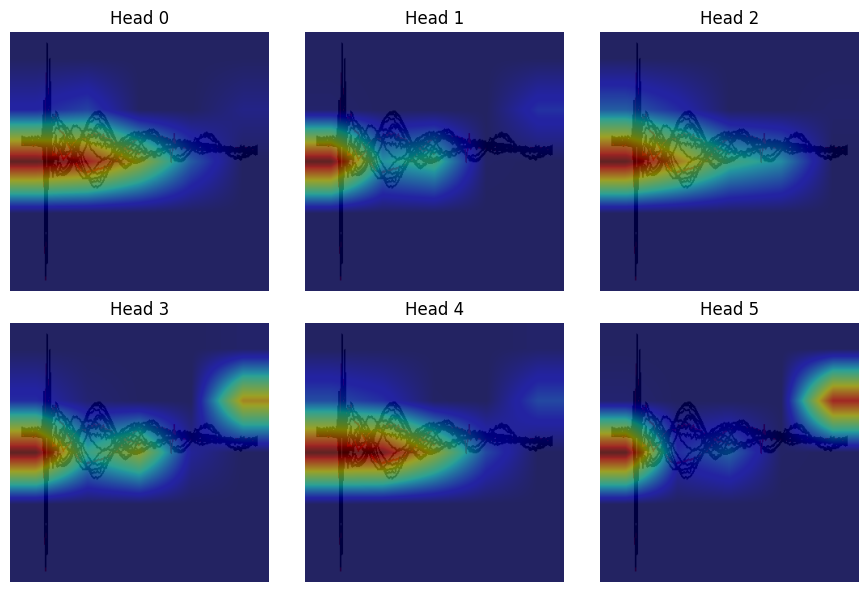

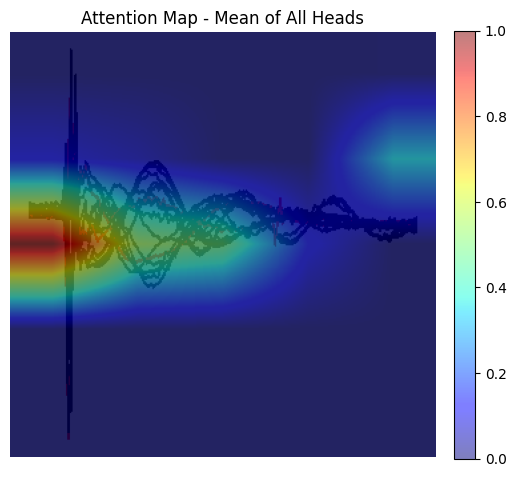

In [ ]:
index = 0
id = 2281
img = X_train[id:id+1, :, :, 0:3]  # (1,H,W,3)
outputs = model.predict(img, batch_size=1)
attention_maps = outputs[1:]

print('Label: ', Y_train[id])
print('Predicted output ', (outputs[0] > 0.5).astype(int)[0])

attn_scores = attention_maps[0][index:index+1]  # shape (1, num_heads, seq_len, seq_len)
plot_patch_attention_heads(img, attn_scores)
plot_patch_attention_all_heads(img, attn_scores)

## Case 2:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Label:  [0 0 0 1]
Predicted output  [0 0 0 1]


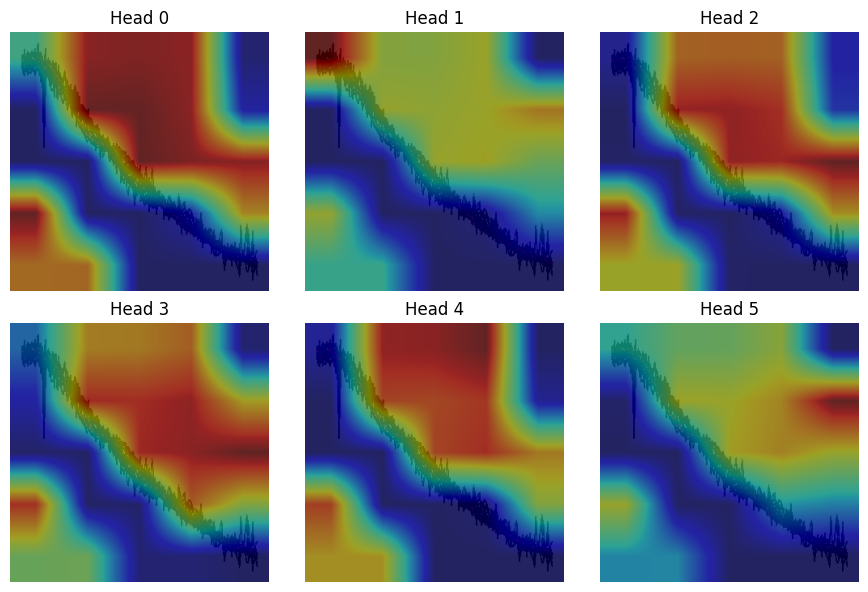

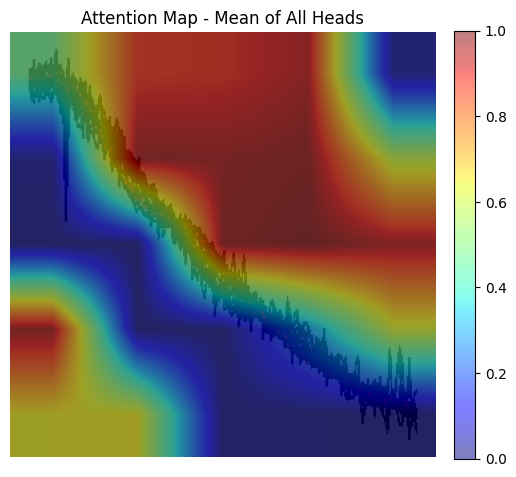

In [ ]:
index = 0
id = 5966
img = X_train[id:id+1, :, :, 0:3]  # (1,H,W,3)
outputs = model.predict(img, batch_size=1)
attention_maps = outputs[1:]

print('Label: ', Y_train[id])
print('Predicted output ', (outputs[0] > 0.5).astype(int)[0])

attn_scores = attention_maps[0][index:index+1]  # shape (1, num_heads, seq_len, seq_len)
plot_patch_attention_heads(img, attn_scores)
plot_patch_attention_all_heads(img, attn_scores)

## Case 3:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Label:  [1 1 1 0]
Predicted output  [1 1 1 0]


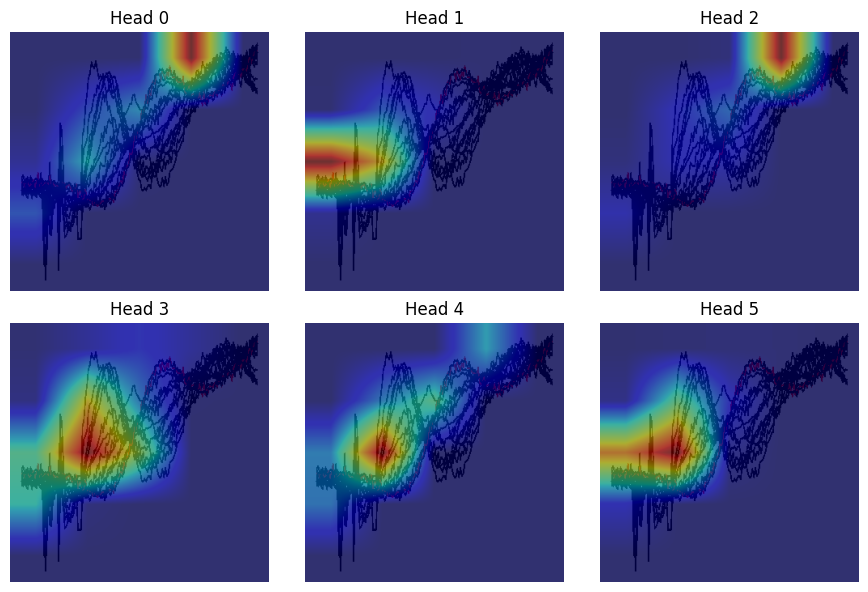

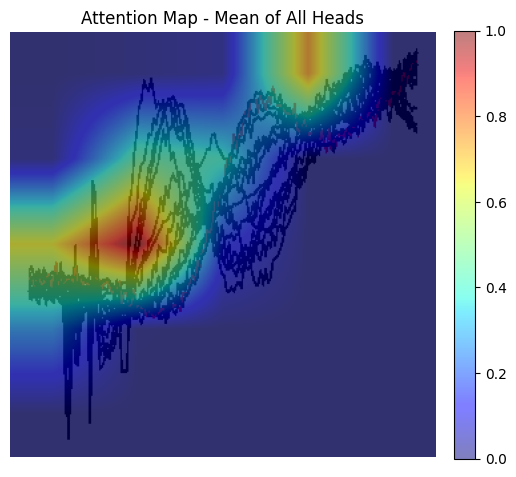

In [ ]:
index = 0
id = 828
img = X_train[id:id+1, :, :, 0:3]  # (1,H,W,3)
outputs = model.predict(img, batch_size=1)
attention_maps = outputs[1:]

print('Label: ', Y_train[id])
print('Predicted output ', (outputs[0] > 0.5).astype(int)[0])

attn_scores = attention_maps[0][index:index+1]  # shape (1, num_heads, seq_len, seq_len)
plot_patch_attention_heads(img, attn_scores)
plot_patch_attention_all_heads(img, attn_scores)